Your patient comes in. They're having a stinging pain in the chest. The X-Ray shows a shadow on the lung. And that shadow is air. If not treated a "collapsed lung"(-ish), or "air on the wrong side of the lung", can result in death.

[What's a Pneumothorax?](https://en.wikipedia.org/wiki/Pneumothorax)

Problem is in an X-Ray, air is usually the thing you ignore. The general idea is:

- Black: Air
- Gray: Fluids and Tissue
- White: Bone and Solids

So the issue is that an air enclosure may just be a mild disturbance in the chest xray. Considering convolutional neural networks are exceptional at identifying abnormalities, we may want them to take a look, as not to miss these tiny abnormalities.


![Futuristic view of human](https://www.publicdomainpictures.net/pictures/50000/nahled/anatomy-high-tech.jpg)

In this challenge, we get chest xrays and masks. In challenges I link below, only bounding boxes were available. Here, we actually get to do dense prediction.

I'm hiding some cells for readability below, just fork the kernel or click the "Show code" on the right to see imports etc. This kernel is just giving some starting info and how to look at the data with the given tools. 

Sources I used and further reading:

- https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
- https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data/data

Some ideas that might be helpful:

- [Check out Pneumonia X-Ray Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge)
- [Use TFRecords](https://www.kaggle.com/lyonzy/convert-dicom-images-to-tfrecords)
- [Check Out Unets](https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import glob

import pydicom

print(os.listdir("../input/siim-acr-pneumothorax-segmentation"))
print()
print(os.listdir("../input/siim-acr-pneumothorax-segmentation/sample images"))
# Any results you write to the current directory are saved as output.

from matplotlib import cm
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K

import tensorflow as tf

from tqdm import tqdm_notebook

import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')

from mask_functions import rle2mask

['sample images', 'mask_functions.py', 'sample_submission.csv', 'download_images.py']

['1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm', '1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397.dcm', '1.2.276.0.7230010.3.1.4.8323329.4982.1517875185.837576.dcm', '1.2.276.0.7230010.3.1.4.8323329.12743.1517875241.599591.dcm', '1.2.276.0.7230010.3.1.4.8323329.4440.1517875182.865105.dcm', '1.2.276.0.7230010.3.1.4.8323329.10003.1517875220.942420.dcm', '1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709.dcm', '1.2.276.0.7230010.3.1.4.8323329.1314.1517875167.222290.dcm', 'train-rle-sample.csv', '1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580.dcm', '1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530.dcm']


Using TensorFlow backend.


## What is DICOM?

Dicom is a format that has metadata, as well as Pixeldata attached to it. Below I extract some basic info with an image. You will know about the gender and age of the patient, as well as info how the image is sampled and generated. Quite useful to programatically read. Here's the [Wikipedia](https://en.wikipedia.org/wiki/DICOM) article for it.

In [2]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


Let's first take a look at the sample images that are available. You'll be able to transfer this kernel to downloaded data, to visualize other bits and explore their metadata.

Filename.........: ../input/siim-acr-pneumothorax-segmentation/sample images/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 17d405a3-a0d2-4901-b33a-63906aa48d9f, 
Patient id..........: 17d405a3-a0d2-4901-b33a-63906aa48d9f
Patient's Age.......: 38
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 130476 bytes
Pixel spacing....: ['0.168', '0.168']


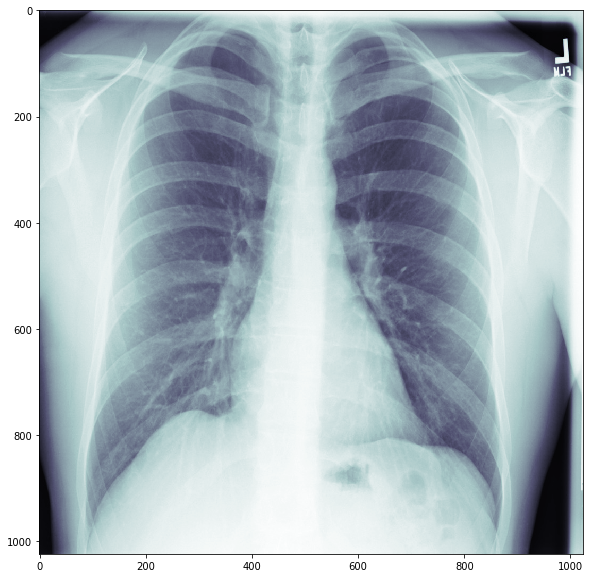

In [3]:
for file_path in glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm'):
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    break # Comment this out to see all

## How do the masks look like?

First let's look at all the sample images. We can see different modes of collection. It becomes very evident, that we have to be careful about the top right marker on the image. The different L may mess with our data. Could it be usable leakage as it points to the hospital it was taken at? Yes, yes it could, but I'm *sure* Kaggle took care of this.

Then we'll look at 3 images and the masks that come with it. Personally, I can't really make out how to find the pneumothorax in the images. Play around with it, in some of the other images, it is definitely more visible than in others. Also (thanks to Ehsan) make sure to transpose the masks!

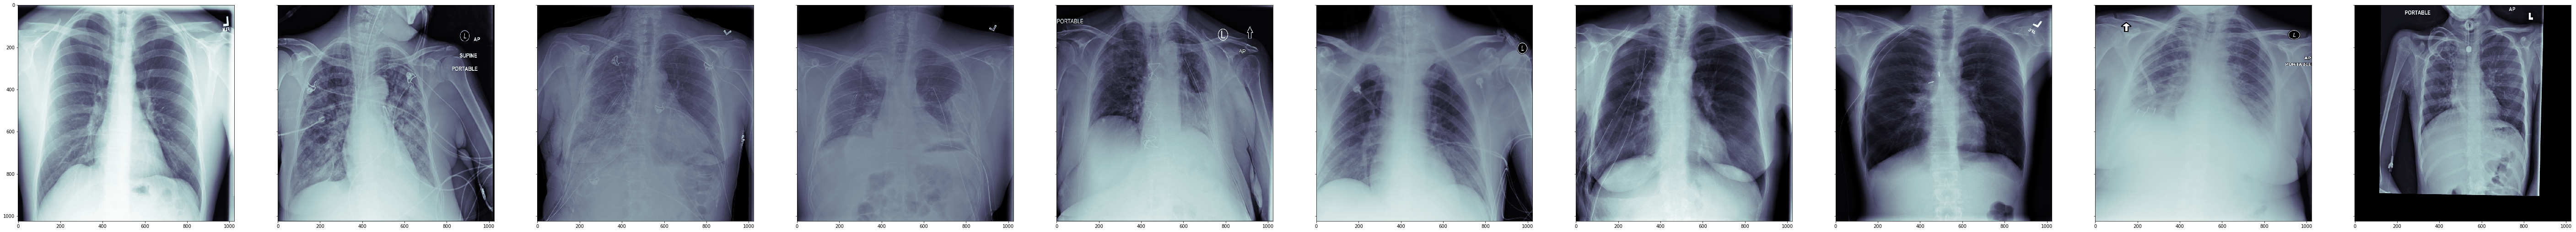

In [4]:
num_img = len(glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm'))
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm')):
    dataset = pydicom.dcmread(file_path)
    #show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)

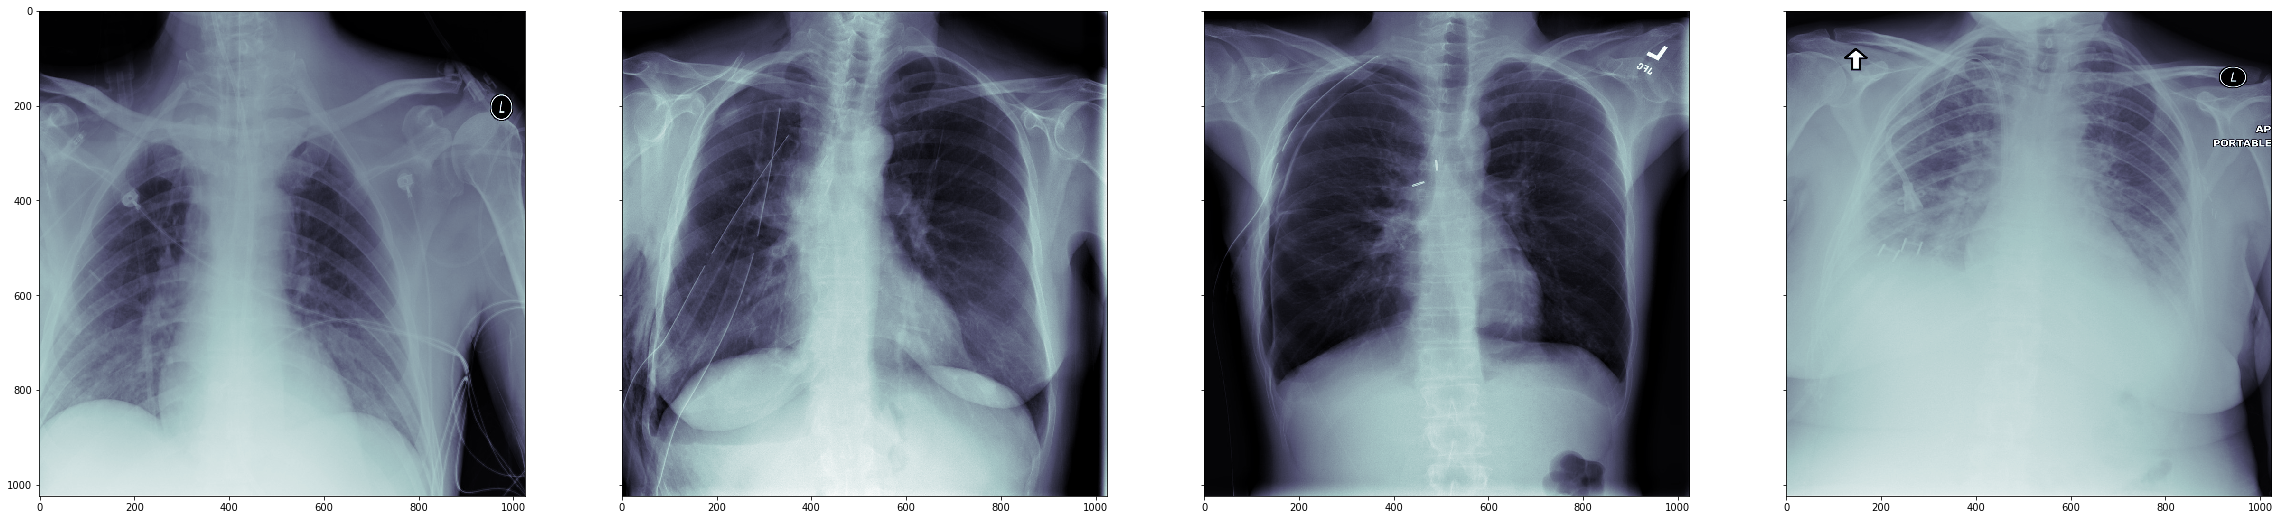

In [5]:
start = 5   # Starting index of images
num_img = 4 # Total number of images to show

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm')[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    #show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)


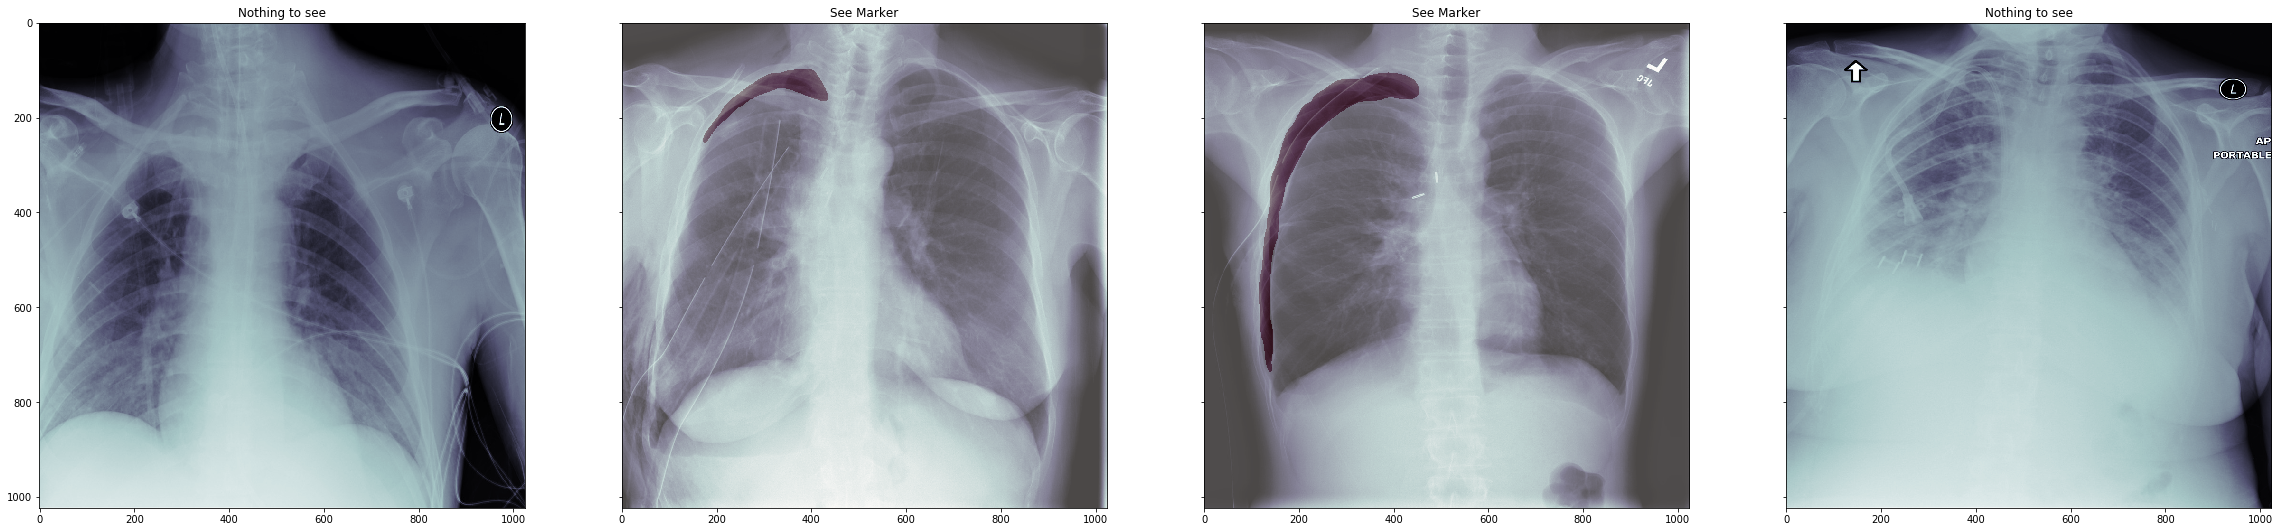

In [6]:
df = pd.read_csv('../input/siim-acr-pneumothorax-segmentation/sample images/train-rle-sample.csv', header=None, index_col=0)

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm')[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    #print(file_path.split('/')[-1][:-4])
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    if df.loc[file_path.split('/')[-1][:-4],1] != '-1':
        mask = rle2mask(df.loc[file_path.split('/')[-1][:-4],1], 1024, 1024).T
        ax[q].set_title('See Marker')
        ax[q].imshow(mask, alpha=0.3, cmap="Reds")
    else:
        ax[q].set_title('Nothing to see')


## Vanilla Unet
So how would we work the data on GCP?

I'd suggest a very nice [Unet](https://arxiv.org/abs/1505.04597), maybe use a pretty pre-trained encoder instead of the following. They're excellent on small-ish datasets and particularly on image segmentation. There are many others you may try, but maybe this one will get you started.

![](http://deeplearning.net/tutorial/_images/unet.jpg)

### Load Full Dataset

In [7]:
train_glob = '../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/*/*/*.dcm'
test_glob = '../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-test/*/*/*.dcm'
train_fns = sorted(glob.glob(train_glob))[:5000]
test_fns = sorted(glob.glob(test_glob))[:5000]
df_full = pd.read_csv('../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/train-rle.csv', index_col='ImageId')

In [8]:
df_full.columns

Index([' EncodedPixels'], dtype='object')

This is the point I shake my fist at unstripped strings...

In [9]:
im_height = 1024
im_width = 1024
im_chan = 1
# Get train images and masks
X_train = np.zeros((len(train_fns), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_fns), im_height, im_width, 1), dtype=np.bool)
print('Getting train images and masks ... ')
sys.stdout.flush()
for n, _id in tqdm_notebook(enumerate(train_fns), total=len(train_fns)):
    dataset = pydicom.read_file(_id)
    X_train[n] = np.expand_dims(dataset.pixel_array, axis=2)
    try:
        if '-1' in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
            Y_train[n] = np.zeros((1024, 1024, 1))
        else:
            if type(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']) == str:
                Y_train[n] = np.expand_dims(rle2mask(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024), axis=2)
            else:
                Y_train[n] = np.zeros((1024, 1024, 1))
                for x in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
                    Y_train[n] =  Y_train[n] + np.expand_dims(rle2mask(x, 1024, 1024), axis=2)
    except KeyError:
        print(f"Key {_id.split('/')[-1][:-4]} without mask, assuming healthy patient.")
        Y_train[n] = np.zeros((1024, 1024, 1)) # Assume missing masks are empty masks.

print('Done!')

Getting train images and masks ... 


Key 1.2.276.0.7230010.3.1.4.8323329.10231.1517875222.737143 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.10362.1517875223.377845 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.10407.1517875223.567351 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.10599.1517875224.488727 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.1068.1517875166.144255 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.11104.1517875231.169401 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.11215.1517875231.757436 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.11557.1517875233.601090 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.11566.1517875233.640521 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.11577.1517875233.694347 without mask, assuming healthy patient.
K

### Build Patches
Reshape to get non-overlapping patches.

In [10]:
im_height = 128
im_width = 128
X_train = X_train.reshape((-1, im_height, im_width, 1))
Y_train = Y_train.reshape((-1, im_height, im_width, 1))

In [11]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [12]:
inputs = Input((None, None, im_chan))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 8 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 8 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 8 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

### Train a scrappy network

Definitely work in progress though.

In [13]:
model.fit(X_train, Y_train, validation_split=.2, batch_size=512, epochs=30)

Train on 256000 samples, validate on 64000 samples
Epoch 1/30
256000/256000 [==============================] - 225s 881us/step - loss: 0.0766 - dice_coef: 0.0057 - val_loss: 0.0220 - val_dice_coef: 0.0049
Epoch 2/30
256000/256000 [==============================] - 218s 852us/step - loss: 0.0197 - dice_coef: 0.0068 - val_loss: 0.0208 - val_dice_coef: 0.0065
Epoch 3/30
256000/256000 [==============================] - 218s 853us/step - loss: 0.0188 - dice_coef: 0.0072 - val_loss: 0.0203 - val_dice_coef: 0.0068
Epoch 4/30
256000/256000 [==============================] - 219s 854us/step - loss: 0.0186 - dice_coef: 0.0078 - val_loss: 0.0202 - val_dice_coef: 0.0056
Epoch 5/30
256000/256000 [==============================] - 219s 855us/step - loss: 0.0186 - dice_coef: 0.0080 - val_loss: 0.0201 - val_dice_coef: 0.0066
Epoch 6/30
256000/256000 [==============================] - 219s 857us/step - loss: 0.0184 - dice_coef: 0.0083 - val_loss: 0.0204 - val_dice_coef: 0.0060
Epoch 7/30
256000/256000 

This isn't working as well as I'd like it to, but I'll leave it here for now. The data is loading, the model is training, I'm still hoping for clarification on the submission, as there is a mismatch between the `smaple_submission.csv` and the provided data.

Better ideas are to use proper train / validation splits, possibly with [stratification](https://en.wikipedia.org/wiki/Stratified_sampling) and consider using a nice [Generator](https://keras.io/preprocessing/image/) instead. Particularly, it may be benefitial not training on 1024x1024 images, but patches of the image. [This kernel](https://www.kaggle.com/toregil/a-lung-u-net-in-keras) might be interesting, but there are many on kaggle on lung segmentation, [mine on salt segmentation](https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics), or the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge) challenge.

## Learnings from Other Segmentation Challenges

These are of course some learnings I gained, but they are from the amazing kagglers in all the links, so please give them the credits. (Especially [Heng CherKeng](https://www.kaggle.com/hengck23), learned a bunch from them and the list below is heavily influenced by them.)

As losses go, definitely check out [IOU / Jaccard](Intersection over union), [Lovasz](https://arxiv.org/abs/1705.08790), and [Focal methods](https://arxiv.org/abs/1708.02002), although [Dice](https://arxiv.org/abs/1707.03237) is the LB loss. You'll probably enjoy [Hypercolumns](https://arxiv.org/abs/1411.5752), [Squeeze & Excitation](https://arxiv.org/abs/1803.02579), [Data Distillation](https://arxiv.org/abs/1712.04440), maybe some [Global Attention](https://arxiv.org/abs/1805.10180) in your Upsampling, and even sprinkle in some [Stochastic Weight Averaging](https://towardsdatascience.com/stochastic-weight-averaging-a-new-way-to-get-state-of-the-art-results-in-deep-learning-c639ccf36a). Some [common tricks on kaggle image segmentation](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984#latest-425973) are:

- Look at the masks! (There be dragons.)
- Analyze the metadata! (There be leakage.)


- Predict empty masks (Binary Classification)
- Break down problem (Male / Female Networks? Multiclass?)
- Active learning of sorting out easy and hard to classify images (Confidence Intervals)


- Pesudo-labeling, semi-suervised learning, knowledge distillation, adversarial training
- Additional labeling or supervisory signal 
- Clustering (KNN for image patches)
